## 1. 데이터 로드 & 전처리
- MNIST 다운로드 (train/test)
- `[0,1]` 정규화, 채널 차원 추가
- `28×28 → 32×32` **제로패딩** 적용


In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype('float32') / 255.0)[..., np.newaxis]  # (N, 28, 28, 1)
x_test  = (x_test.astype('float32')  / 255.0)[..., np.newaxis]

# 28x28 -> 32x32 (상하좌우 2px 제로패딩)
pad = ((0, 0), (2, 2), (2, 2), (0, 0))
x_train = np.pad(x_train, pad, mode='constant')
x_test  = np.pad(x_test,  pad, mode='constant')

print('x_train:', x_train.shape, 'y_train:', y_train.shape)
print('x_test :', x_test.shape,  'y_test :', y_test.shape)


x_train: (60000, 32, 32, 1) y_train: (60000,)
x_test : (10000, 32, 32, 1) y_test : (10000,)


### 샘플 시각화
학습 전에 일부 이미지를 확인합니다.


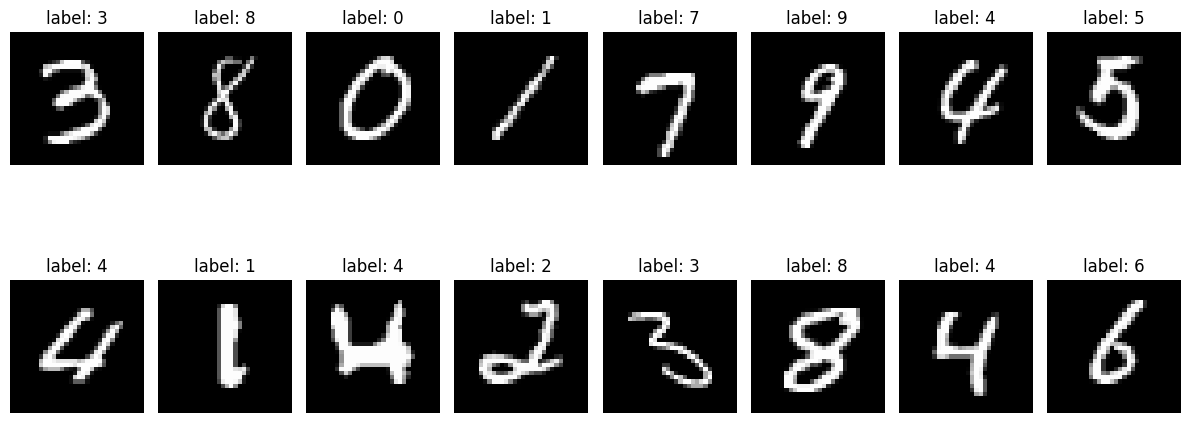

In [2]:
n = 16
indices = np.random.choice(len(x_train), size=n, replace=False)
imgs = x_train[indices]
labels = y_train[indices]

cols = 8
rows = (n + cols - 1) // cols
plt.figure(figsize=(12, 3*rows))
for i in range(n):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f'label: {labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


## 2. LeNet-5 모델 정의
아키텍처: **C1 → S2 → C3 → S4 → C5 → F6 → Output**
- **C1**: Conv(5×5, 6), tanh, valid → 28×28
- **S2**: AvgPool(2×2, s=2) + tanh → 14×14
- **C3**: Conv(5×5, 16), tanh, valid → 10×10
- **S4**: AvgPool(2×2, s=2) + tanh → 5×5
- **C5**: Conv(5×5, 120), tanh, valid → 1×1
- **F6**: Dense(84), tanh
- **Output**: RBFLayer(10)


In [3]:
from tensorflow.keras import layers, models
import tensorflow as tf

class RBFLayer(layers.Layer):
    def __init__(self, units, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(self.units, int(input_shape[-1])),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = tf.expand_dims(inputs, axis=1) - tf.expand_dims(self.mu, axis=0)
        l2 = tf.reduce_sum(tf.pow(diff, 2), axis=2)
        exp = tf.exp(-1 * l2)
        return exp


def build_lenet5(input_shape=(32,32,1), num_classes=10):
    inputs = layers.Input(shape=input_shape, name='input_32x32')

    # C1
    x = layers.Conv2D(6, kernel_size=5, strides=1, padding='valid',
                      activation='tanh', name='C1')(inputs)
    # S2
    x = layers.AveragePooling2D(pool_size=2, strides=2, name='S2_pool')(x)
    x = layers.Activation('tanh', name='S2_tanh')(x)

    # C3
    x = layers.Conv2D(16, kernel_size=5, strides=1, padding='valid',
                      activation='tanh', name='C3')(x)

    # S4
    x = layers.AveragePooling2D(pool_size=2, strides=2, name='S4_pool')(x)
    x = layers.Activation('tanh', name='S4_tanh')(x)

    # C5
    x = layers.Conv2D(120, kernel_size=5, strides=1, padding='valid',
                      activation='tanh', name='C5')(x)

    # F6
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(84, activation='tanh', name='F6')(x)

    # Output - Replace Softmax with RBF
    outputs = RBFLayer(num_classes, name='OUTPUT')(x) # You might need to tune gamma

    model = models.Model(inputs=inputs, outputs=outputs, name='LeNet5')
    return model

model = build_lenet5()
model.summary()

Model: "LeNet5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_32x32 (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C1 (Conv2D)                     │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ S2_pool (AveragePooling2D)      │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ S2_tanh (Activation)            │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C3 (Conv2D)                     │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ S4_pool (AveragePooling2D)      │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ S4_tanh (Activation)            │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C5 (Conv2D)                     │ (None, 1, 1, 120)      │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ F6 (Dense)                      │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OUTPUT (RBFLayer)               │ (None, 10)             │           840 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,696 (241.00 KB)

 Trainable params: 61,696 (241.00 KB)

 Non-trainable params: 0 (0.00 B)

## 3. 컴파일
- Optimizer: **SGD(momentum=0.9, lr=0.01)**
- Loss: **sparse_categorical_crossentropy**
- Metric: **accuracy**


In [4]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


## 4. 학습
- 기본: `epochs=20`, `batch_size=128`, `validation_split=0.1`


In [5]:
history = model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=20,
    validation_split=0.1,
    verbose=1
)


Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.6533 - loss: 1.2140 - val_accuracy: 0.9453 - val_loss: 0.1900
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9413 - loss: 0.1973 - val_accuracy: 0.9690 - val_loss: 0.1083
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9664 - loss: 0.1075 - val_accuracy: 0.9802 - val_loss: 0.0728
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9767 - loss: 0.0785 - val_accuracy: 0.9833 - val_loss: 0.0621
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9804 - loss: 0.0640 - val_accuracy: 0.9862 - val_loss: 0.0507
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9824 - loss: 0.0563 - val_accuracy: 0.9860 - val_loss: 0.0477
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9863 - loss: 0.0460 - val_accuracy: 0.9845 - val_loss: 0.0504
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9864 - loss: 0.0439 - val_accuracy: 

## 5. 평가
테스트 세트 정확도와 손실을 출력합니다.


In [6]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss    : {test_loss:.4f}')


Test accuracy: 0.9879
Test loss    : 0.0379


## 6. 학습 곡선 시각화
accuracy / loss 변화를 시각화합니다.


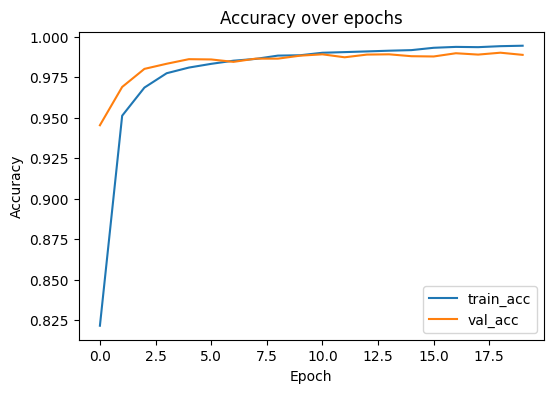

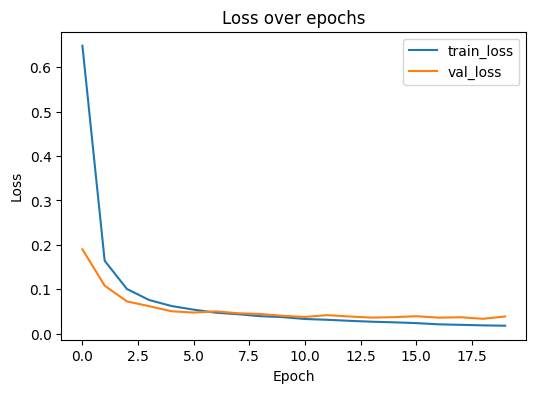

In [8]:
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()
